## OCOM5203M Assignment 2 - Image Caption Generation [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 75% of the final grade for the module.

### Motivation

Through this coursework, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image to text model.
> 3. Use and compare two different text similarity metrics for evaluating an image to text model, and understand evaluation challenges.


### Setup and resources

Having a GPU will speed up the image feature extraction process. You can use Google Colab to complete this assingment.

Please implement the coursework using Python and PyTorch (i.e., Keras and TensorFlow are not accepted).

This coursework will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5029.

To download the data:

> 1. **Images**: download the zip file "coco_subset_images.zip (812MB)" [here](https://leeds365-my.sharepoint.com/:f:/g/personal/busmnom_leeds_ac_uk/EuAH3b6a4g9IjTNhroLLXPoB6ho6cwxYSNh885ZzrktYZA?e=QGSYpf).
> 2. **Reference captions**: on the COCO [download page](https://cocodataset.org/#download), download the file named "2017 Train/Val annotations (241MB)".
> 3. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format.
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.


Final note:

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your full name:

In [ ]:
Dina Ranchhod

## Imports

Feel free to add to this section as needed.

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.utils as utils
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
import json
import re
import random
import math
import itertools
from numpy.linalg import norm

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN).

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks.

We will first extract the feature representations of the images from the Encoder and save them (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Overview

> 1. Extracting image features
> 2. Text preparation of training and validation data
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]
11/11

### 1.1 EncoderCNN

Read through the template EncoderCNN class below and complete the class.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # Removing top fc layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        return features

In [ ]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 148MB/s]


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

### 1.2 Processing the images

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Creating custom Dataset for the images
class ImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and f.lower().endswith('.jpg')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]

        # Defining the image path
        img_path = os.path.join(self.root_dir, file_name)

        # Opening the image and converting to RGB
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'file_name': file_name}

In [ ]:
root_dir = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/images"

# Loading in the images from root directory and applying given transformation
images_dataset = ImagesDataset(
    root_dir,
    transform=data_transform)

# DataLoader for batching and shuffling
dataloader = DataLoader(
    images_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 2)

In [ ]:
# Reading in the `coco_subset_meta.csv` file
meta_data = pd.read_csv("/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/coco_subset_meta.csv")
meta_data.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145
1,1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000...,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_...,262146
2,2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000...,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d...,524291
3,3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000...,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_...,262148
4,4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb...,393223


In [ ]:
# Checking the number of unique id's matches the number of images in COCO_5029
meta_data['id'].nunique() == 5029

True

In [ ]:
# List of unique image id's
unique_id = meta_data['id'].unique()

# Creating an empty dictionary with image id as keys to store image features
image_id_dict = {id: None for id in unique_id}

In [ ]:
# Iterate through the dataloader
for batch in dataloader:
    images = batch['image'].to(device)

    # Forward pass through the encoder to get features
    with torch.no_grad():
        features = encoder(images)

    # Extract file names from the batch and update the features in the dictionary
    file_names = batch['file_name']
    for i in range(len(file_names)):
        # Extracting image ID without leading 0's and without '.jpg' extension
        file_name = file_names[i].split('.')[0]

        # Skip file names containing "(1)", i.e. duplicates
        if "(1)" in file_name:
            continue
        else:
            file_num = int(file_name)

        # Update features in the dictionary with the correct shape
        image_id_dict[file_num] = features[i].cpu().numpy().reshape(1, 2048)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [ ]:
# Saving image_id_id
path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/image_id_dict.pt"
torch.save(image_id_dict, path)

In [ ]:
# Retrieving image_id_dict
path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/image_id_dict.pt"
image_id_dict = torch.load(path)

In [ ]:
# torch.save(features, 'features.pt')

## 2 Text preparation [23 marks]

23/23

### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="df_caption_set.png" alt="images matched to caption" width="700"/>

In [ ]:
# Loading in the `captions_train2017.json` file
with open("/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/annotations/captions_train2017.json", 'r') as file:
    data = json.load(file)

# Annotations dictionary
captions = data['annotations']

Some inspection/exploration of the data:

In [ ]:
# Keys in data dictionary
keys = data.keys()
print(keys)

dict_keys(['info', 'licenses', 'images', 'annotations'])


In [ ]:
# Data types in each key
for key in keys:
  print(key)
  print(type(data[key]))

info
<class 'dict'>
licenses
<class 'list'>
images
<class 'list'>
annotations
<class 'list'>


In [ ]:
# Convert the captions to a DataFrame for easier exploration
captions = pd.DataFrame(captions)

pd.set_option('display.max_colwidth', None)
captions.head(10)

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wheel.
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind a legally parked car
3,106140,98,A large passenger airplane flying through the air.
4,106140,101,There is a GOL plane taking off in a partly cloudy sky.
5,322141,109,Blue and white color scheme in a small bathroom.
6,322141,121,This is a blue and white bathroom with a wall sink and a lifesaver on the wall.
7,322141,163,A blue boat themed bathroom with a life preserver on the wall
8,203564,181,The bike has a clock as a tire.
9,16977,185,two cars parked on the sidewalk on the street


In [ ]:
# Number of unique image_id's in `captions_train2017.json`
captions['image_id'].nunique()

118287

In [ ]:
# Some exploration of size and contents of captions DataFrame
print(captions.shape)
print(captions.info())

(591753, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591753 entries, 0 to 591752
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  591753 non-null  int64 
 1   id        591753 non-null  int64 
 2   caption   591753 non-null  object
dtypes: int64(2), object(1)
memory usage: 13.5+ MB
None


In [ ]:
# Displaying the `coco_subset_meta.csv` file, loaded in earlier
meta_data.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000262145.jpg,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_5f08387bde_z.jpg,262145
1,1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000262146.jpg,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_1f653cdb80_z.jpg,262146
2,2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000524291.jpg,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg,524291
3,3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000262148.jpg,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_547e6b22ae_z.jpg,262148
4,4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000393223.jpg,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb1184cd_z.jpg,393223


In [ ]:
# Renaming 'id' and 'file_name' columns in meta_data
meta_data = meta_data.rename(columns={'id': 'image_id'})
meta_data = meta_data.rename(columns={'file_name': 'filename'})

# Filtering meta_data for relevant columns to join with captions DataFrame
metadata = meta_data[['image_id', 'filename']]
metadata.head()

,image_id,filename
0,262145,000000262145.jpg
1,262146,000000262146.jpg
2,524291,000000524291.jpg
3,262148,000000262148.jpg
4,393223,000000393223.jpg


In [ ]:
# Checking number of unique image_id's in `coco_subset_meta.csv`
metadata['image_id'].nunique() == 5029

True

In [ ]:
# Some exploration of size and contents of metadata DataFrame
print(metadata.shape)
print(metadata.info())

(8000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  8000 non-null   int64 
 1   filename  8000 non-null   object
dtypes: int64(1), object(1)
memory usage: 125.1+ KB
None


In [ ]:
# Merging captions DataFrame with metadata DataFrame to obtain data with filename attached
captions_df = pd.merge(captions, metadata, on = 'image_id', how = 'left')
captions_df.tail(10)

,image_id,id,caption,filename
606602,180285,829636,"Two women smiling together, one holds a stuffed animal the other has a stuffed animal on her shoulder.",000000180285.jpg
606603,180285,829636,"Two women smiling together, one holds a stuffed animal the other has a stuffed animal on her shoulder.",000000180285.jpg
606604,180285,829653,Two women smile for the camea while posing iwth some suffed animals,000000180285.jpg
606605,180285,829653,Two women smile for the camea while posing iwth some suffed animals,000000180285.jpg
606606,133071,829655,a slice of bread is covered with a sour cream and quacamole,NaN
606607,410182,829658,A long plate hold some fries with some sliders next to them,NaN
606608,180285,829665,Two women sit and pose with stuffed animals.,000000180285.jpg
606609,180285,829665,Two women sit and pose with stuffed animals.,000000180285.jpg
606610,133071,829693,White Plate with a lot of guacamole and an extra large dollop of sour cream over meat,NaN
606611,133071,829717,A dinner plate has a lemon wedge garnishment.,NaN


From the last 10 rows of the updated captions DataFrame, there are some NaN entries in the filename column. This is expected since the captions data includes captions for more images than we have in the COCO_5029 image set. We should remove any rows in captions which have no filename since these rows contain captions for images we don't have in our images file.

In [ ]:
# Count of how many NaN's in each column
print(captions_df.isna().sum())

# Removing any rows with NaN in 'filename' column
captions_df = captions_df.dropna(subset=['filename'])
captions_df = captions_df.reset_index(drop=True)

print(captions_df.isna().sum())

image_id         0
id               0
caption          0
filename    566599
dtype: int64
image_id    0
id          0
caption     0
filename    0
dtype: int64


In [ ]:
# Information on the shape and columns of the captions_df DataFrame
print(captions_df.shape)
print(captions_df.info())

(40013, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40013 entries, 0 to 40012
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  40013 non-null  int64 
 1   id        40013 non-null  int64 
 2   caption   40013 non-null  object
 3   filename  40013 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
None


In [ ]:
captions_df.head(10)

,image_id,id,caption,filename
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg
3,410627,2961,The young man is stirring his pot of food with a wooden spoon.,000000410627.jpg
4,554037,5010,"a counter with vegetables, knife and cutting board on it.",000000554037.jpg
5,554037,5433,"asparragus, lemons and a bowl of rice on a counter top",000000554037.jpg
6,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg
7,143370,5786,A bathroom with a poster of an ugly face above the toilette.,000000143370.jpg
8,554037,6108,"The preparation of salmon, asparagus and lemons.",000000554037.jpg
9,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg


In [ ]:
# Checking the number of unique image_id's in captions_df DataFrame
captions_df['image_id'].nunique() == 5029

True

In [ ]:
# Checking the number of unique filename's in captions_df DataFrame
captions_df['filename'].nunique() == 5029

True

### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed.

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.

In [ ]:
# Defining a function to clean text strings
clean_string = lambda text: re.sub(r'[^a-zA-Z\s]', '', text).lower()

captions_df['cleaned_caption'] = captions_df['caption'].apply(clean_string)

In [ ]:
# Sampling 10 random rows from captions_df
sampled_rows = captions_df.sample(10)

# Printing the original and cleaned captions for 10 random index's
for index, row in sampled_rows.iterrows():
    print(f"Index: {index}")
    print(f"Original Caption: {row['caption']}")
    print(f"Cleaned Caption: {row['cleaned_caption']}")
    print()

Index: 13924
Original Caption:  a group of people riding bikes down the streets
Cleaned Caption:  a group of people riding bikes down the streets

Index: 36374
Original Caption: A man sits outside on a small laptop.
Cleaned Caption: a man sits outside on a small laptop

Index: 18927
Original Caption: A snowy street with street signs and hoses connected to a hydrant.
Cleaned Caption: a snowy street with street signs and hoses connected to a hydrant

Index: 33215
Original Caption: Three laptop computers with the same image on screen.
Cleaned Caption: three laptop computers with the same image on screen

Index: 3503
Original Caption: A very busy city street with buses, vans, and semis.
Cleaned Caption: a very busy city street with buses vans and semis

Index: 25240
Original Caption: Many different types of fruits and vegetables sit on a counter. 
Cleaned Caption: many different types of fruits and vegetables sit on a counter 

Index: 8042
Original Caption: A person on a court with a tenni

### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [ ]:
# List of unique image ID's
unique_id = captions_df['image_id'].unique()

# Splitting the image ID's using function defined above
split_data = split_ids(unique_id)

In [ ]:
# Filtering the captions_df for train, valid and test image ID's
train_data = captions_df[captions_df['image_id'].isin(split_data[0])]
train_data = train_data.reset_index(drop=True)

valid_data = captions_df[captions_df['image_id'].isin(split_data[1])]
valid_data = valid_data.reset_index(drop=True)

test_data = captions_df[captions_df['image_id'].isin(split_data[2])]
test_data = test_data.reset_index(drop=True)

### 2.3 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    # Converting list of word ID's to sentence
    def id_to_words(self, id_list):
        return ' '.join([self.idx2word[word_id] for word_id in id_list])

    def id_to_words_clean(self, id_list):
        return ' '.join([self.idx2word[word_id] for word_id in id_list if self.idx2word[word_id] not in ['<end>', '<pad>']])

Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [ ]:
# Combining cleaned captions from train_data and valid_data
all_cleaned_cap = train_data['cleaned_caption'].tolist() + valid_data['cleaned_caption'].tolist()

# Split the captions into words
all_words = [word for caption in all_cleaned_cap for word in caption.split()]

# Count the occurrence of each word
word_count = Counter(all_words)

In [ ]:
# Creating the vocabulary
vocab = Vocabulary()

# Add words to the vocabulary that appear more than 3 times
for word, count in word_count.items():
    if count > 3:
        vocab.add_word(word)

# Print length of the vocabulary
print(len(vocab))

3120


### 2.4 The Dataset and DataLoader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [ ]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: DataFrame containing image_id, cleaned_caption columns
            features: Dictionary mapping image_id to image features
            vocab: vocabulary wrapper
        """
        self.df = df
        self.features = features
        self.vocab = vocab
        self.max_caption_length = 47

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """

        # Extract image_id and cleaned_caption from df
        caption = self.df['cleaned_caption'][index]
        image_id = self.df['image_id'][index]

        # Extracting image features from dictionary
        image_features = torch.Tensor(self.features[image_id]).squeeze(0)

        # Converting captions into word ID's
        caption_id = [self.vocab(word) for word in caption.split()]
        caption_id.append(self.vocab('<end>'))
        caption_padded = caption_id + [self.vocab('<pad>')] * (self.max_caption_length - len(caption_id))

        # True caption length (including <end> token)
        true_length = len(caption_id)

        # Convert word IDs to tensor
        caption_padded = torch.Tensor(caption_padded).long()

        return image_features, caption_padded, true_length, image_id

    def __len__(self):
        return len(self.df)

In [ ]:
# Create COCO_Subset instances for train, valid and test data
train_coco_subset = COCO_Subset(train_data, image_id_dict, vocab)
valid_coco_subset = COCO_Subset(valid_data, image_id_dict, vocab)
test_coco_subset = COCO_Subset(test_data, image_id_dict, vocab)

# Create DataLoader instances for train, valid and test data
train_dataloader = DataLoader(
    train_coco_subset,
    batch_size=64,
    shuffle=True)

valid_dataloader = DataLoader(
    valid_coco_subset,
    batch_size=64,
    shuffle=False)

test_dataloader = DataLoader(
    test_coco_subset,
    batch_size=64,
    shuffle=False)

Loading one batch of the training set, and:
- printing out the shape of each returned Tensor
- printing an example of a padded Word ID
- printing its corresponding sentence
- printing its corresponding cleaned sentence (without `<end>` and `<pad>` tokens)
- checking the length of each padded Word ID is 47
- printing the true lengths of 5 random captions

In [ ]:
for batch in train_dataloader:
    image_features, caption_padded, true_lengths, image_keys = batch

    # Print the shape of each tensor
    print("Image Features Shape:", image_features.shape)
    print("Word IDs Shape:", caption_padded.shape)
    print("True Lengths Shape:", true_lengths.shape)
    print("Image Keys Shape:", len(image_keys))

    print()
    print()

    # Printing some word IDs and their corresponding sentences
    for i in range(min(3, len(caption_padded))):
        print(f"Example {i + 1} - Image Key: {image_keys[i]}")
        print("Word IDs:", caption_padded[i].tolist())
        print("Sentence:", vocab.id_to_words(caption_padded[i].tolist()))
        print("Cleaned Sentence:", vocab.id_to_words_clean(caption_padded[i].tolist()))
        print()

    print()

    # Check the length of all caption_padded
    all_lengths_correct = all(len(caption_padded[i]) == 47 for i in range(len(caption_padded)))
    print(f"All lengths uniform: {all_lengths_correct}")


    # Print the true length for 5 random captions
    for _ in range(5):
        rand_idx = random.randint(0, len(true_lengths) - 1)
        print(f"True Length for Example {rand_idx + 1}: {true_lengths[rand_idx].item()}")

    break  # Stop after the first batch

Image Features Shape: torch.Size([64, 2048])
Word IDs Shape: torch.Size([64, 47])
True Lengths Shape: torch.Size([64])
Image Keys Shape: 64


Example 1 - Image Key: 41005
Word IDs: [646, 443, 114, 235, 21, 12, 324, 413, 451, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sentence: four skiers are standing on a snow covered hill <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Cleaned Sentence: four skiers are standing on a snow covered hill

Example 2 - Image Key: 82053
Word IDs: [12, 5, 6, 842, 21, 12, 734, 32, 3, 52, 11, 1038, 32, 3, 405, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sentence: a man is working on a laptop in the city with flags in the background <end> <pad> <pad> <pad> <pad> <

In [ ]:
# train_iter = iter(train_loader)
# features, captions, lengths = train_iter.next()
# print(features.shape)
# print(captions.shape)
# print(lengths.shape)

## 3 Train DecoderRNN [15 marks]

15/15

### 3.1 Define the encoder model

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=512, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths, image_id):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        self.bn.eval()
        im_features = self.bn(im_features)
        self.bn.train()

        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs, image_id


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

### 3.2 Train the decoder

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:
# A function to calculate the loss for validation data
def calc_loss(loader, net):

  loss_fn = nn.CrossEntropyLoss()
  running_loss = 0.0
  n = 0   # counter for number of mini batches

  with torch.no_grad():
    for batch in loader:
      features, captions, lengths, image_id = batch

      features = features.to(device)
      captions = captions.to(device)
      lengths = lengths.cpu()

      outputs_id = net(features, captions, lengths, image_id)
      outputs = outputs_id[0]

      packed_targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)

      # accumulate loss
      running_loss += loss_fn(outputs, packed_targets.data)
      n += 1

  return running_loss/n

In [ ]:
import torch.optim as optim
import torch.nn.utils as utils

decoder = DecoderRNN(len(vocab)).to(device)

nepochs = 50
results_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/epochs50_rnn.pt"
losses = np.zeros((2, nepochs))

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters())

# Set the decoder to training mode
decoder.train()

for epoch in range(nepochs):

    running_loss = 0.0
    n = 0

    for batch in train_dataloader:
        features, captions, lengths, image_id = batch

        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.cpu()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_id = decoder(features, captions, lengths, image_id)
        outputs = outputs_id[0]

        # Pack the targets using pack_padded_sequence
        packed_targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)

        # Compute the loss
        loss = loss_fn(outputs, packed_targets.data)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5)
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        n += 1

    # Calculate mean loss for the epoch
    loss_train = running_loss / n
    decoder.eval()
    loss_valid = calc_loss(valid_dataloader, decoder).item()
    decoder.train()
    losses[:,epoch] = (loss_train, loss_valid)

    print(f"Epoch {epoch+1}:  Training Loss:{loss_train : .5f}   Validation Loss:{loss_valid : .5f}")

# Save the trained model
torch.save({"state_dict": decoder.state_dict(), "losses": losses}, results_path)

Epoch 1:  Training Loss: 3.80568   Validation Loss: 3.46029
Epoch 2:  Training Loss: 2.84975   Validation Loss: 3.15782
Epoch 3:  Training Loss: 2.35689   Validation Loss: 3.10236
Epoch 4:  Training Loss: 2.01207   Validation Loss: 3.11163
Epoch 5:  Training Loss: 1.73808   Validation Loss: 3.16054
Epoch 6:  Training Loss: 1.52286   Validation Loss: 3.23323
Epoch 7:  Training Loss: 1.34091   Validation Loss: 3.29145
Epoch 8:  Training Loss: 1.19959   Validation Loss: 3.37707
Epoch 9:  Training Loss: 1.07699   Validation Loss: 3.44282
Epoch 10:  Training Loss: 0.98233   Validation Loss: 3.53804
Epoch 11:  Training Loss: 0.90638   Validation Loss: 3.60161
Epoch 12:  Training Loss: 0.83834   Validation Loss: 3.67679
Epoch 13:  Training Loss: 0.78116   Validation Loss: 3.76716
Epoch 14:  Training Loss: 0.73736   Validation Loss: 3.84456
Epoch 15:  Training Loss: 0.69494   Validation Loss: 3.93479
Epoch 16:  Training Loss: 0.66281   Validation Loss: 3.99232
Epoch 17:  Training Loss: 0.63873

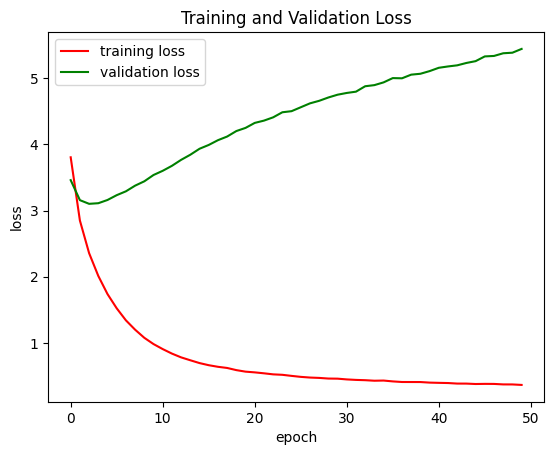

In [ ]:
# restore model parameters and losses
results_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/epochs50_rnn.pt"
data = torch.load(results_path)
losses = data["losses"]

# Plot training and validation losses for each epoch
fig, ax = plt.subplots()
plt.plot(losses[0], 'r', label = 'training loss')
plt.plot(losses[1], 'g', label = 'validation loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.show()

The plot above shows that the model starts to overfit after the first few epochs; the training loss continues to decrease as the validation loss increases with each epoch.

Typically, this indicates that the model is learning the training data so well to the point where it is memorising the examples rather than learning the underlying patterns. To combat this we can introduce the dropout regularisation technique which randomly decativates a specified percentage of neurons during each training iteration. The aim is to force the network to rely on a more robust and diverse set of features, leading to better generalisation.

Additionally, since overfitting becomes apparent in the first few epochs, implementing an early stopping technique will be beneficial. The model's performance on validation data is monitered and training is stopped if the validation loss does not improve for 5 consecutive epochs.

In [ ]:
class DecoderRNN_drop(nn.Module):
    def __init__(self, vocab_size, embed_size=512, hidden_size=512, num_layers=1, max_seq_length=47, dropout_rate = 0.5):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN_drop, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, features, captions, lengths, image_id):
        """Decode image feature vectors and generates captions."""
        embeddings = self.dropout(self.embed(captions))
        im_features = self.resize(features)
        self.bn.eval()
        im_features = self.bn(im_features)
        self.bn.train()

        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0]) # hiddens[0]
        return outputs, image_id


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)    # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))      # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                  # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.dropout(self.embed(predicted))   # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)          # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

To determine the best percentage dropout to use we can test a range and select the best one.

In [ ]:
import itertools

# A range of hyperparameter values to search
dropout_rates = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Dictionary to store the results
results_dropout = {}

for drop in dropout_rates:
    # Create a new instance of the DecoderRNN_drop with the current dropout rate
    decoder_drop = DecoderRNN_drop(len(vocab), dropout_rate=drop).to(device)

    # Set up optimizer with the new instance
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(decoder_drop.parameters())

    decoder_drop.train()

    nepochs = 50

    # Continue with your training loop
    losses = []
    best_valid_loss = float('inf')  # Set an initial high value for best validation loss
    patience = 5  # Number of epochs with no improvement after which training will be stopped

    for epoch in range(nepochs):
        running_loss = 0.0
        n = 0

        for batch in train_dataloader:
            features, captions, lengths, image_id = batch

            features = features.to(device)
            captions = captions.to(device)
            lengths = lengths.cpu()

            optimizer.zero_grad()

            outputs_id = decoder_drop(features, captions, lengths, image_id)
            outputs = outputs_id[0]

            packed_targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)

            loss = loss_fn(outputs, packed_targets.data)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(decoder_drop.parameters(), max_norm=5)
            optimizer.step()

            running_loss += loss.item()
            n += 1

        loss_train = running_loss / n
        decoder_drop.eval()
        loss_valid = calc_loss(valid_dataloader, decoder_drop).item()
        decoder_drop.train()
        losses.append((loss_train, loss_valid))

        print(f"Drop {drop}: Epoch {epoch+1}: Training Loss:{loss_train : .5f}   Validation Loss:{loss_valid : .5f}")

        # Check for early stopping
        if loss_valid < best_valid_loss:
            best_valid_loss = loss_valid
            # Save the model state when validation loss improves
            results_dropout[drop] = {'losses': losses, 'model_state_dict': decoder_drop.state_dict()}
        else:
            # If no improvement, decrement patience
            patience -= 1
            if patience == 0:
                print(f"No improvement for {patience+5} epochs. Early stopping.")
                break

Drop 0.2: Epoch 1: Training Loss: 3.85844   Validation Loss: 3.47138
Drop 0.2: Epoch 2: Training Loss: 2.94130   Validation Loss: 3.15599
Drop 0.2: Epoch 3: Training Loss: 2.49776   Validation Loss: 3.08250
Drop 0.2: Epoch 4: Training Loss: 2.19821   Validation Loss: 3.07454
Drop 0.2: Epoch 5: Training Loss: 1.97260   Validation Loss: 3.09287
Drop 0.2: Epoch 6: Training Loss: 1.78681   Validation Loss: 3.14236
Drop 0.2: Epoch 7: Training Loss: 1.64170   Validation Loss: 3.18984
Drop 0.2: Epoch 8: Training Loss: 1.52315   Validation Loss: 3.23029
Drop 0.2: Epoch 9: Training Loss: 1.41522   Validation Loss: 3.27703
No improvement for 5 epochs. Early stopping.
Drop 0.25: Epoch 1: Training Loss: 3.90438   Validation Loss: 3.51715
Drop 0.25: Epoch 2: Training Loss: 3.04256   Validation Loss: 3.21509
Drop 0.25: Epoch 3: Training Loss: 2.58508   Validation Loss: 3.10507
Drop 0.25: Epoch 4: Training Loss: 2.28240   Validation Loss: 3.08144
Drop 0.25: Epoch 5: Training Loss: 2.06192   Validatio

In [ ]:
# Saving the results_dropout dictionary
results_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/best_step.pt"
torch.save(results_dropout, results_path)

In [ ]:
# Retreiving the results_dropout dictionary
results_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/best_step.pt"
results_dropout = torch.load(results_path)

In [ ]:
# Displaying the optimal dropout rate
best_drop_rate = min(results_dropout, key=lambda x: results_dropout[x]['losses'][-6][1])
print("Best Dropout Rate:", best_drop_rate)

# Displaying losses in each epoch for optimal dropout rate
best_losses = results_dropout[best_drop_rate]['losses']
best_losses

Best Dropout Rate: 0.5


[(3.954239426959645, 3.477071762084961),
 (3.058266576311805, 3.1745262145996094),
 (2.668244469165802, 3.087298631668091),
 (2.4216133925047787, 3.063328981399536),
 (2.2405907335606488, 3.05859112739563),
 (2.1002054704861206, 3.0762181282043457),
 (1.984410767663609, 3.0973997116088867),
 (1.8842810823158784, 3.121286392211914),
 (1.8034767159006813, 3.157926321029663),
 (1.7298069027337162, 3.195297956466675)]

From the above, 0.5 has been found to be the best dropout percentage for the model.

In [ ]:
nepochs = 50
loss_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/epochs50_rnn_dropout.pt"
model_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/best_dropout_model.pt"
losses = []

decoder_drop = DecoderRNN_drop(len(vocab), dropout_rate = 0.5).to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder_drop.parameters())

# Setting up early stopping
best_valid_loss = float('inf')
patience = 5
counter = 0

# Set the decoder to training mode
decoder_drop.train()

for epoch in range(nepochs):

    running_loss = 0.0
    n = 0

    for batch in train_dataloader:
        features, captions, lengths, image_id = batch

        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.cpu()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_id = decoder_drop(features, captions, lengths, image_id)
        outputs = outputs_id[0]

        # Pack the targets using pack_padded_sequence
        packed_targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)

        # Compute the loss
        loss = loss_fn(outputs, packed_targets.data)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder_drop.parameters(), max_norm=5)
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        n += 1

    # Calculate mean loss for the epoch
    loss_train = running_loss / n

    # Calculate loss for validation data
    decoder_drop.eval()
    loss_valid = calc_loss(valid_dataloader, decoder_drop).item()
    decoder_drop.train()

    losses.append((loss_train, loss_valid))

    # Check for early stopping
    if loss_valid < best_valid_loss:
        best_valid_loss = loss_valid
        # Save the model state when validation loss improves
        torch.save(decoder_drop, model_path)
        counter = 0  # Reset patience counter
    else:
        # If no improvement, increment patience counter
        counter += 1
        if counter >= patience:
            print(f"No improvement for {counter} epochs. Early stopping.")
            break

    print(f"Epoch {epoch+1}:  Training Loss:{loss_train : .5f}   Validation Loss:{loss_valid : .5f}")

torch.save({"state_dict": decoder_drop.state_dict(), "losses": losses}, loss_path)

Epoch 1:  Training Loss: 3.98720   Validation Loss: 3.56514
Epoch 2:  Training Loss: 3.11835   Validation Loss: 3.22095
Epoch 3:  Training Loss: 2.71303   Validation Loss: 3.09482
Epoch 4:  Training Loss: 2.45795   Validation Loss: 3.06579
Epoch 5:  Training Loss: 2.27026   Validation Loss: 3.07221
Epoch 6:  Training Loss: 2.12223   Validation Loss: 3.08499
Epoch 7:  Training Loss: 1.99400   Validation Loss: 3.10333
Epoch 8:  Training Loss: 1.89936   Validation Loss: 3.12309
No improvement for 5 epochs. Early stopping.


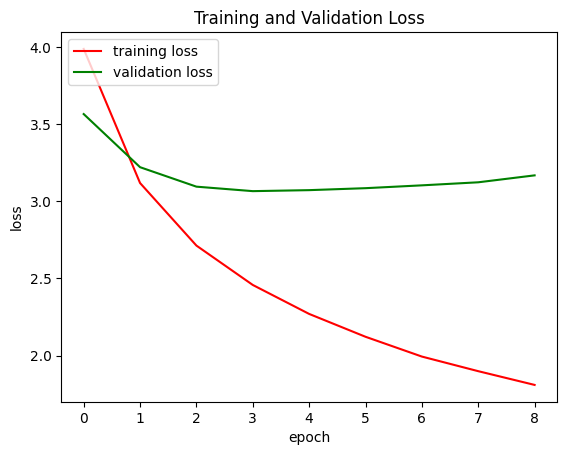

In [ ]:
# restore model parameters and losses
loss_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/epochs50_rnn_dropout.pt"
data = torch.load(loss_path)
losses = data["losses"]
training_losses = [item[0] for item in losses]
validation_losses = [item[1] for item in losses]


# Plot training and validation losses for each epoch
fig, ax = plt.subplots()
plt.plot(training_losses, 'r', label='training loss')
plt.plot(validation_losses, 'g', label='validation loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Retrieving the decoder model before overfitting starts
model_path = "/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/results/best_dropout_model.pt"
decoder_best = torch.load(model_path)

From the output and the plot, the validation loss is still high despite enforcing dropout and early stopping regularization methods.This suggests that the generalisation error for the model will be high and generated captions are expected to differ significantly from reference captions.

I have tried many variations of hyperparameters, varying the loss function, varying the optimizer, varying the learning rate but cannot get the validation loss lower that 3. Model performance is expected to be moderate/average.

## 4 Generate predictions on test data [8 marks]

5/8

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['image_id', 'reference_caption', 'generated_caption'])

# Set the decoder to evaluation mode
decoder_best.eval()

DecoderRNN_drop(
  (resize): Linear(in_features=2048, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(3120, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3120, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Running test set through the model, generating captions
with torch.no_grad():
    for batch in test_dataloader:
        features, captions, lengths, image_id = batch
        features = features.to(device)
        sampled_ids = decoder_best.sample(features)

        # Convert the generated captions to sentences
        generated_sentences = [
            [vocab.idx2word[word_id.item()] for word_id in sequence if word_id.item() not in [0, 1, 2]]
            for sequence in sampled_ids
        ]

        # Convert the reference captions to sentences
        reference_sentences = [
            [vocab.idx2word[word_id.item()] for word_id in sequence if word_id.item() not in [0, 1, 2]]
            for sequence in captions
        ]

        # Flatten the lists of sentences into strings
        generated_caption = [' '.join(sentence) for sentence in generated_sentences]
        reference_caption = [' '.join(sentence) for sentence in reference_sentences]

        # Create a DataFrame for the current batch
        batch_df = pd.DataFrame({
            'image_id': image_id.numpy(),
            'reference_caption': reference_caption,
            'generated_caption': generated_caption
        })

        # Append the batch DataFrame to the overall results_df
        results_df = pd.concat([results_df, batch_df], ignore_index=True)

In [ ]:
# A function to open the image given image_id
def open_image(image_id, image_path="/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2/images/"):
    # Construct the full path to the image
    filename = str(image_id).zfill(12) + '.jpg'
    full_im_path = os.path.join(image_path, filename)

    # Load and plot the image
    image = plt.imread(full_im_path)
    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.show()

Image ID: 65712
Reference Caption: a person walking on a city street with an umbrella
Generated Caption: a man and a woman are standing in front of a building


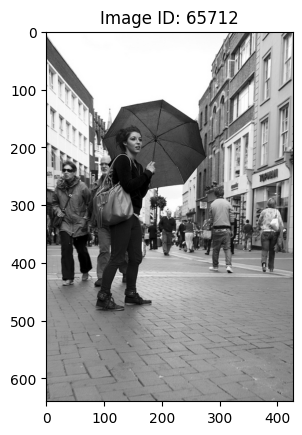


Image ID: 352440
Reference Caption: a person is skiing down a steep mountain
Generated Caption: a group of people on skis and snowboards on a beach off the ocean off the ocean off the snow


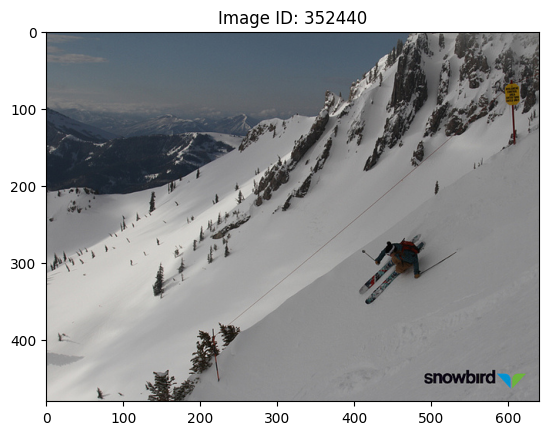


Image ID: 514089
Reference Caption: a young girl holding a toothbrush in her mouth
Generated Caption: a little girl holding a sword in her hand


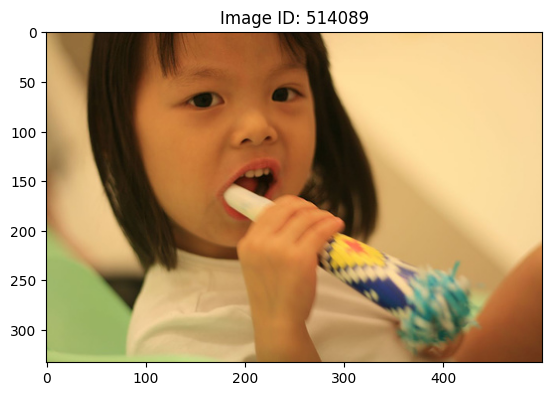


Image ID: 565438
Reference Caption: a young man is doing a trick on his skateboard
Generated Caption: a man on a skateboard on a skateboard a ramp


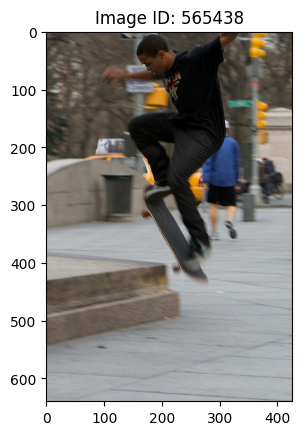


Image ID: 106664
Reference Caption: a man flying through the air while riding a snowboard
Generated Caption: a man riding a wave on a surfboard on the ocean off the camera off the camera off the camera off the camera to


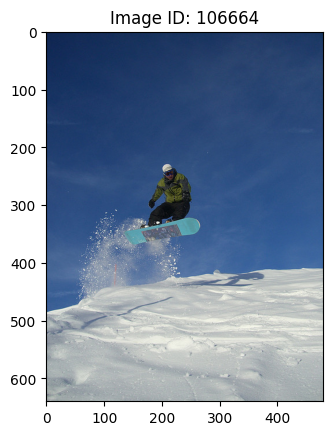

In [ ]:
# Randomly selecting 5 random results
random_index = results_df.sample(5).index

# Iterate over the selected indexes
for idx in random_index:
    # Retrieve information from the corresponding row
    row = results_df.loc[idx]

    image_id = row['image_id']
    reference_caption = row['reference_caption']
    generated_caption = row['generated_caption']

    # Print captions
    print(f"Image ID: {image_id}")
    print(f"Reference Caption: {reference_caption}")
    print(f"Generated Caption: {generated_caption}")

    # Display the image
    open_image(image_id)
    print()

## 5 Caption evaluation using BLEU score [10 marks]

6/10

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# New DataFrame to hold BLEU scores
bleu_df = pd.DataFrame()

# Adding image_id column to bleu_df
bleu_df['image_id'] = results_df['image_id']

# Function to split a caption into a list of words
def split_caption_list(caption):
  return caption.split()

# Adding generated caption split into list of words
bleu_df['generated_caption'] = results_df['generated_caption'].apply(split_caption_list)

In [ ]:
# Function to get all reference captions for a given image_id
def get_all_ref_captions(image_id):
    filtered_df = results_df[results_df['image_id'] == image_id]
    ref_captions_list = []

    for _, row in filtered_df.iterrows():
        ref_captions_list.append(split_caption_list(row['reference_caption']))

    return ref_captions_list

# Adding list of lists of words for each reference caption
bleu_df['reference_captions'] = bleu_df['image_id'].apply(get_all_ref_captions)

In [ ]:
bleu_df.head()

,image_id,generated_caption,reference_captions
0,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]"
1,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]"
2,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]"
3,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]"
4,143370,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[[a, bathroom, with, a, poster, of, an, face, above, the], [a, bathroom, with, a, white, toilet, and, sink], [large, bathroom, with, light, flowing, in, the, window], [a, small, bathroom, with, a, toilet, by, the, window, and, a, pedestal, sink, with, a, mirrored, medicine, cabinet, over, it], [a, bathroom, with, a, toilet, and, a, sink]]"


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Function for calculating BLEU score
def bleu_score(row):
    return sentence_bleu(row['reference_captions'], row['generated_caption'])

# Function for calculating 2-gram (bigram) BLEU score
def bleu_score_bi(row):
    return sentence_bleu(row['reference_captions'], row['generated_caption'], weights=(0.5, 0.5))


In [ ]:
# Adding BLEU score to bleu_df
bleu_df['bleu_score'] = bleu_df.apply(bleu_score, axis=1)

# Adding Bigram BLEU score to bleu_df
bleu_df['bleu_score_bi'] = bleu_df.apply(bleu_score_bi, axis=1)

bleu_df.head()

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

,image_id,generated_caption,reference_captions,bleu_score,bleu_score_bi
0,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]",6.848991e-155,0.210819
1,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]",6.848991e-155,0.210819
2,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]",6.848991e-155,0.210819
3,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]",6.848991e-155,0.210819
4,143370,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[[a, bathroom, with, a, poster, of, an, face, above, the], [a, bathroom, with, a, white, toilet, and, sink], [large, bathroom, with, light, flowing, in, the, window], [a, small, bathroom, with, a, toilet, by, the, window, and, a, pedestal, sink, with, a, mirrored, medicine, cabinet, over, it], [a, bathroom, with, a, toilet, and, a, sink]]",3.018385e-01,0.346410


From the above we can see that there are some duplicated rows. Since the list of reference captions have been added to each generated caption, we can remove the duplicated rows without losing any information.

Removing the duplicates will ensure the frequencies in the histogram are accurate.

Before removing duplicate rows we should check that generated captions for each image ID are identical.

In [ ]:
# Checking all generated captions are identical for each image_id
for image_id in results_df['image_id'].unique():
    subset_df = results_df[results_df['image_id'] == image_id]
    identical = subset_df['generated_caption'].nunique() == 1
    if not identical:
        print(f"For image_id {image_id}, not all generated_caption entries are identical.")

In [ ]:
bleu_df = bleu_df.drop_duplicates(subset=['image_id'])
bleu_df = bleu_df.reset_index(drop=True)

# Display the resulting DataFrame
bleu_df.head()

,image_id,generated_caption,reference_captions,bleu_score,bleu_score_bi
0,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[[an, airplane, with, its, landing, wheels, out, landing], [a, plane, that, is, taking, off, at, an, airport], [a, man, takes, a, picture, of, an, airplane, taking, off], [a, large, jet, takes, off, from, an, airport, runway], [the, airplane, is, taking, off, on, the, runway, at, the, airport]]",6.848991e-155,0.210819
1,143370,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[[a, bathroom, with, a, poster, of, an, face, above, the], [a, bathroom, with, a, white, toilet, and, sink], [large, bathroom, with, light, flowing, in, the, window], [a, small, bathroom, with, a, toilet, by, the, window, and, a, pedestal, sink, with, a, mirrored, medicine, cabinet, over, it], [a, bathroom, with, a, toilet, and, a, sink]]",3.018385e-01,0.346410
2,40986,"[a, kitchen, with, a, refrigerator, and, a, sink, and, a, sink, and, a, sink, and, a, sink, and, a, toilet]","[[cookies, in, a, pan, on, the, counter, and, baked, cookies, in, a, pan, on, the, stove], [cookies, in, a, pan, on, the, counter, and, baked, cookies, in, a, pan, on, the, stove], [cookies, in, a, pan, on, the, counter, and, baked, cookies, in, a, pan, on, the, stove], [cookies, in, a, pan, on, the, counter, and, baked, cookies, in, a, pan, on, the, stove], [assorted, items, on, a, counter, top, in, a, kitchenette], [assorted, items, on, a, counter, top, in, a, kitchenette], [assorted, items, on, a, counter, top, in, a, kitchenette], [assorted, items, on, a, counter, top, in, a, kitchenette], [a, man, at, the, wall, in, his, kitchen], [a, man, at, the, wall, in, his, kitchen], [a, man, at, the, wall, in, his, kitchen], [a, man, at, the, wall, in, his, kitchen], [two, pans, with, cookies, in, them, sitting, on, a, counter, with, bottles, a, coffee, maker, and, knives], [two, pans, with, cookies, in, them, sitting, on, a, counter, with, bottles, a, coffee, maker, and, knives], [two, pans, with, cookies, in, them, sitting, on, a, counter, with, bottles, a, coffee, maker, and, knives], [two, pans, with, cookies, in, them, sitting, on, a, counter, with, bottles, a, coffee, maker, and, knives], [a, countertop, in, a, kitchen, with, fresh, cookies], [a, countertop, in, a, kitchen, with, fresh, cookies], [a, countertop, in, a, kitchen, with, fresh, cookies], [a, countertop, in, a, kitchen, with, fresh, cookies]]",2.388208e-78,0.162221
3,401556,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[[a, towel, on, a, drying, rack, in, a, bathroom, with, a, wooden, stool], [a, towel, on, a, drying, rack, in, a, bathroom, with, a, wooden, stool], [a, bathroom, with, a, bathtub, and, a, toilet], [a, bathroom, with, a, bathtub, and, a, toilet], [a, beautiful, bathroom, with, a, closed, in, tub], [a, beautiful, bathroom, with, a, closed, in, tub], [three, piece, white, bathroom, with, towel, and, wall], [three, piece, white, bathroom, with, towel, and, wall], [a, bathroom, has, a, slanted, roof, and, red, tile, by, the, bathtub], [a, bathroom, has, a, slanted, roof, and, red, tile, by, the, bathtub]]",1.410002e-01,0.258199
4,314370,"[a, kitchen, with, a, refrigerator, and, a, sink, and, a, sink, and, a, sink, and, a, window, and, a, cat, on, the, floor]","[[a, kitchen, filled, with, clutter, all, over, its, counter], [a, kitchen, is, cluttered, with, cooking, supplies, eggs], [a, kitchen, with, a, stove, and, counter, tops, and, shelves, filled, with, food], [a, large, variety, of, food, spread, out, on, a, counter], [a, kitchen, counter, is, stacked, up, with, food, from, the, store]]",1.225915e-01,0.217786


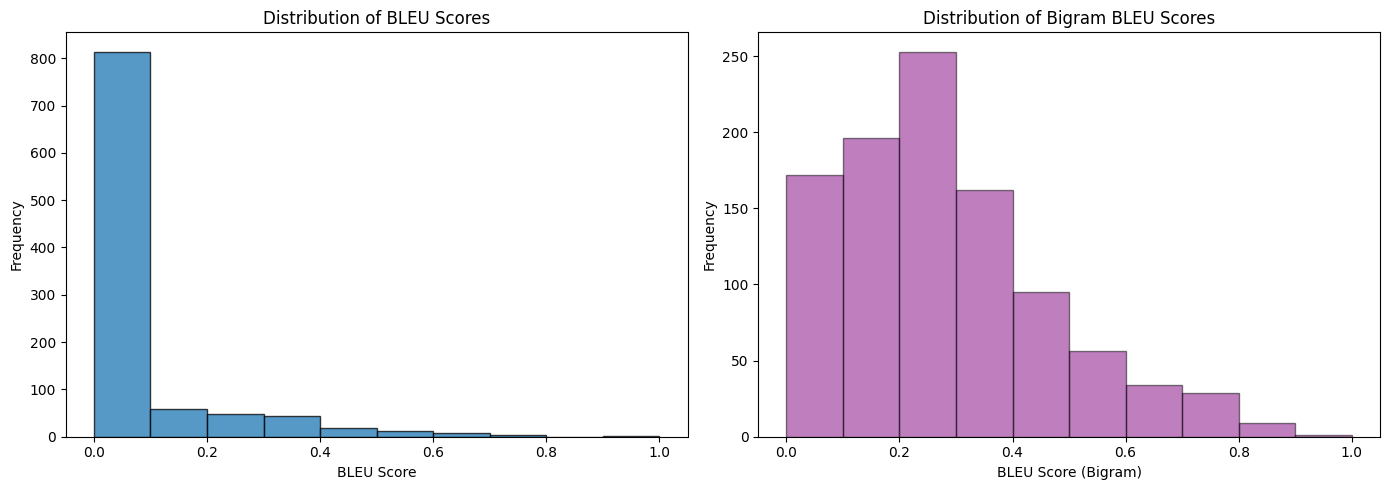

In [ ]:
# Creating histograms of the BLEU and 2-gram BLEU scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].hist(bleu_df['bleu_score'], bins=10, edgecolor='black', alpha = 0.75)
axes[0].set_xlabel('BLEU Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of BLEU Scores')

axes[1].hist(bleu_df['bleu_score_bi'], bins=10, edgecolor='black', color='purple', alpha = 0.5)
axes[1].set_xlabel('BLEU Score (Bigram)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Bigram BLEU Scores')

plt.tight_layout()
plt.show()

### 5.2 BLEU score examples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

High Bigram BLEU Score Example

Image ID: 401613

Predicted Sentence: a man holding a tennis racquet on a court

Bigram BLEU Score: 0.816496580927726

Reference Captions:
-  a young woman holding a tennis racquet on a court
-  a woman tennis player bending her and holding a racket
-  a woman with a tennis racket in a squatting position
-  a woman kneeling a bit while waiting to hit the tennis ball
-  a woman with a tennis racket and in tennis



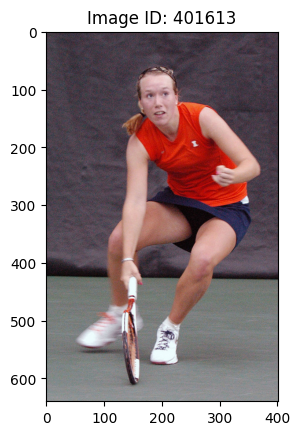

In [ ]:
# Randomly selecting a result with bigram bleu score higher than 0.8
high_bleu_bi = bleu_df[bleu_df['bleu_score_bi'] > 0.8].sample(n=1).squeeze()

# Display information about selected high bigram BLEU score
print("High Bigram BLEU Score Example")
print()
print("Image ID:", high_bleu_bi['image_id'])
print()
print("Predicted Sentence:", ' '.join(high_bleu_bi['generated_caption']))
print()
print("Bigram BLEU Score:", high_bleu_bi['bleu_score_bi'])
print()
print("Reference Captions:")
for ref_caption in high_bleu_bi['reference_captions']:
    print("- ", ' '.join(ref_caption))
print()
open_image(high_bleu_bi['image_id'])

Low Bigram BLEU Score Example

Image ID: 295193

Predicted Sentence: a pizza sitting on a table with a plate of food and a beverage it on a plate and a fork on it a slice of pizza and a beverage on a

Bigram BLEU Score: 0.2129856878426493

Reference Captions:
-  a plate topped with a pizza being cut with a spoon
-  a plate topped with a pizza being cut with a spoon
-  a pizza that looks is being cut into
-  a pizza that looks is being cut into
-  person cutting a pizza with a spoon and pizza cutter
-  person cutting a pizza with a spoon and pizza cutter
-  a plate of pizza being cut with a pizza cutter
-  a plate of pizza being cut with a pizza cutter
-  someone using a pizza cutter to cut this meat and pizza
-  someone using a pizza cutter to cut this meat and pizza



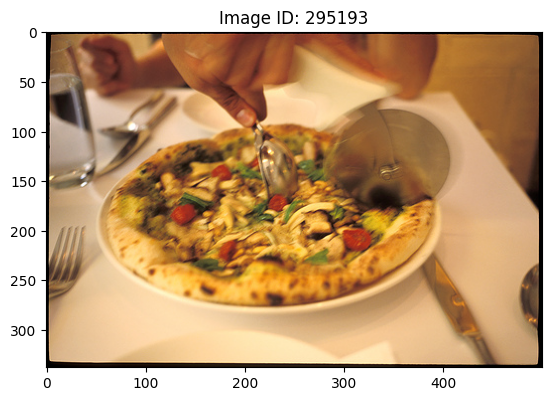

In [ ]:
# Randomly selecting a result with bigram bleu score lower than 0.3
low_bleu_bi = bleu_df[bleu_df['bleu_score_bi'] < 0.3].sample(n=1).squeeze()

# Display information about selected low bigram BLEU score
print("Low Bigram BLEU Score Example")
print()
print("Image ID:", low_bleu_bi['image_id'])
print()
print("Predicted Sentence:", ' '.join(low_bleu_bi['generated_caption']))
print()
print("Bigram BLEU Score:", low_bleu_bi['bleu_score_bi'])
print()
print("Reference Captions:")
for ref_caption in low_bleu_bi['reference_captions']:
    print("- ", ' '.join(ref_caption))
print()
open_image(low_bleu_bi['image_id'])


## 6 Caption evaluation using cosine similarity [12 marks]

12/12

###  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# New DataFrame to hold cosine similarity scores
cosine_df = pd.DataFrame()

# Adding image_id column to cosine_df
cosine_df['image_id'] = results_df['image_id']

# Adding generated caption split into list of words
cosine_df['generated_caption'] = results_df['generated_caption'].apply(split_caption_list)

# Adding reference caption split into list if words
cosine_df['reference_caption'] = results_df['reference_caption'].apply(split_caption_list)

In [ ]:
# Function to calculate average vector of the embedding vector
def average_embedding(embedding_layer, word_list):
    word_embeddings = []

    for word in word_list:
        word_index = vocab(word)

        if word_index != vocab.word2idx['<unk>']:
            embedding_vector = embedding_layer.weight.data[word_index].cpu().numpy()
            word_embeddings.append(embedding_vector)

    avg_vector = np.mean(word_embeddings, axis=0)

    return avg_vector

In [ ]:
# Extracting embedding layer from trained model
embedding_layer = decoder_best.embed

# Adding columns for the average vectors for generated and reference captions
cosine_df['gen_average_vec'] = cosine_df['generated_caption'].apply(lambda x: average_embedding(embedding_layer, x))
cosine_df['ref_average_vec'] = cosine_df['reference_caption'].apply(lambda x: average_embedding(embedding_layer, x))

In [ ]:
from numpy.linalg import norm

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = norm(vec1)
    norm2 = norm(vec2)

    similarity = dot_product / (norm1 * norm2)

    return similarity

In [ ]:
# Calculating cosine similarity between each generated caption and reference caption pair
cosine_df['cosine_similarity'] = cosine_df.apply(lambda row: cosine_similarity(row['gen_average_vec'], row['ref_average_vec']), axis=1)

# Calculating average cosine similarity
cosine_df['average_cosine'] = cosine_df.groupby('image_id')['cosine_similarity'].transform('mean')

# Scaling average cosine similarity from [-1, 1] to [0, 1]
cosine_df['scaled_av_cosine'] = (cosine_df['average_cosine'] + 1) / 2

In [ ]:
# Removing duplicate rows so histogram's not skewed
cosine_df = cosine_df.drop_duplicates(subset=['image_id'])
cosine_df = cosine_df.reset_index(drop=True)

cosine_df[['image_id', 'generated_caption', 'reference_caption', 'cosine_similarity', 'average_cosine', 'scaled_av_cosine']].head()

,image_id,generated_caption,reference_caption,cosine_similarity,average_cosine,scaled_av_cosine
0,57429,"[a, large, jetliner, flying, through, the, air, in, a, field]","[an, airplane, with, its, landing, wheels, out, landing]",0.027225,0.219906,0.609953
1,143370,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[a, bathroom, with, a, poster, of, an, face, above, the]",0.465662,0.620993,0.810496
2,40986,"[a, kitchen, with, a, refrigerator, and, a, sink, and, a, sink, and, a, sink, and, a, sink, and, a, toilet]","[cookies, in, a, pan, on, the, counter, and, baked, cookies, in, a, pan, on, the, stove]",0.336973,0.386635,0.693318
3,401556,"[a, bathroom, with, a, toilet, and, sink, and, a, toilet, and, a, sink, and, a, toilet, and, a, shower, and, a, toilet, and, a, bathroom]","[a, towel, on, a, drying, rack, in, a, bathroom, with, a, wooden, stool]",0.589951,0.577811,0.788905
4,314370,"[a, kitchen, with, a, refrigerator, and, a, sink, and, a, sink, and, a, sink, and, a, window, and, a, cat, on, the, floor]","[a, kitchen, filled, with, clutter, all, over, its, counter]",0.302909,0.383254,0.691627


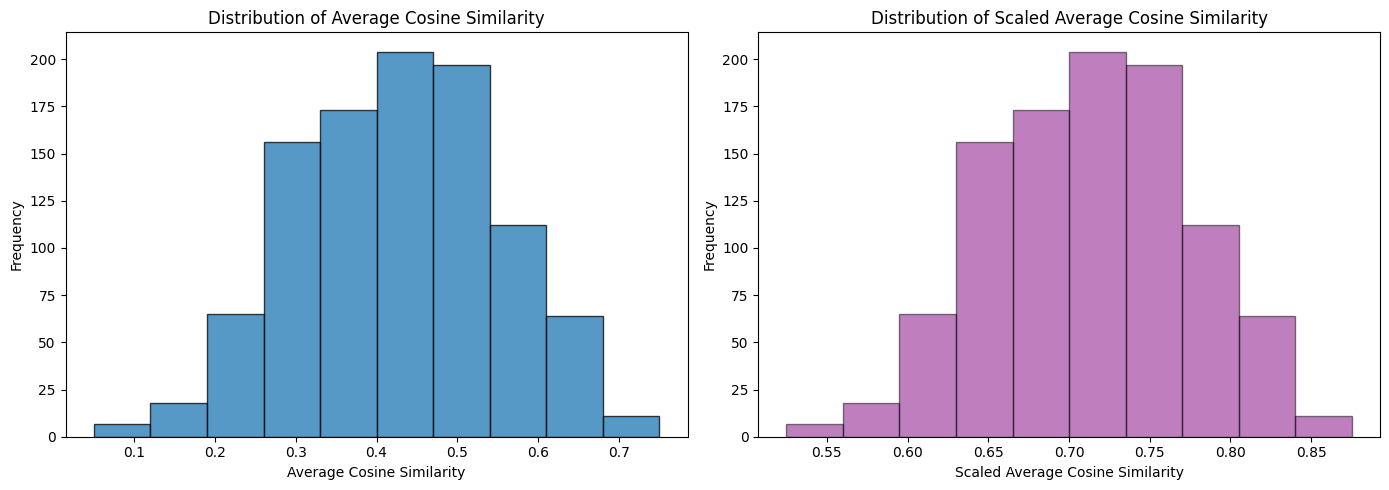

In [ ]:
# Creating histograms of the regular and scaled Average Cosine Similarities
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].hist(cosine_df['average_cosine'], bins=10, edgecolor='black', alpha = 0.75)
axes[0].set_xlabel('Average Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Average Cosine Similarity')

axes[1].hist(cosine_df['scaled_av_cosine'], bins=10, edgecolor='black', color='purple', alpha = 0.5)
axes[1].set_xlabel('Scaled Average Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Scaled Average Cosine Similarity')

plt.tight_layout()
plt.show()

### 6.2 Cosine similarity examples

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

High Scaled Average Cosine Similarity Example

Image ID: 459265

Predicted Sentence: a man holding a tennis racquet on a court

Scaled Average Cosine Similarity: 0.81467557

Reference Captions:
-  a woman in a short skirt holding a tennis racquet
-  a woman is playing a game of tennis
-  woman in a blue dress serving on a tennis court
-  a female serving a tennis ball in front of a crowd
-  a woman serving a tennis ball in a public match



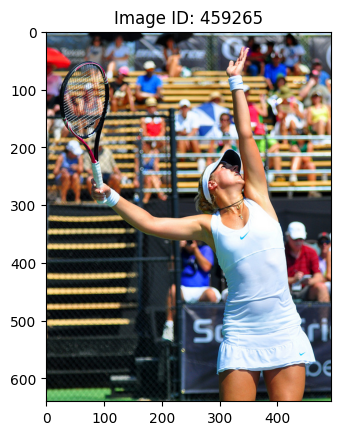

In [ ]:
# Randomly selecting a result with scaled average cosine similarity higher than 0.8
high_cosine = cosine_df[cosine_df['scaled_av_cosine'] > 0.8].sample(n=1).squeeze()

# Display information about selected high cosine similarity
print("High Scaled Average Cosine Similarity Example")
print()
print("Image ID:", high_cosine['image_id'])
print()
print("Predicted Sentence:", ' '.join(high_cosine['generated_caption']))
print()
print("Scaled Average Cosine Similarity:", high_cosine['scaled_av_cosine'])
print()
print("Reference Captions:")
for ref_caption in bleu_df[bleu_df['image_id'] == high_cosine['image_id']]['reference_captions']:
  for cap in ref_caption:
    print("- ", ' '.join(cap))
print()
open_image(high_cosine['image_id'])

Low Scaled Average Cosine Similarity Example

Image ID: 573568

Predicted Sentence: a person riding a wave on a surfboard on the ocean off the ocean off the camera off the camera off the camera off the

Scaled Average Cosine Similarity: 0.5985383

Reference Captions:
-  a skier takes a fall while going down a slope
-  someone skiing on the hill of snow at night
-  a person on skis crashing down a ski slope
-  a person on skis falling down a snowy slope
-  man fallen and sliding down mountain side slope



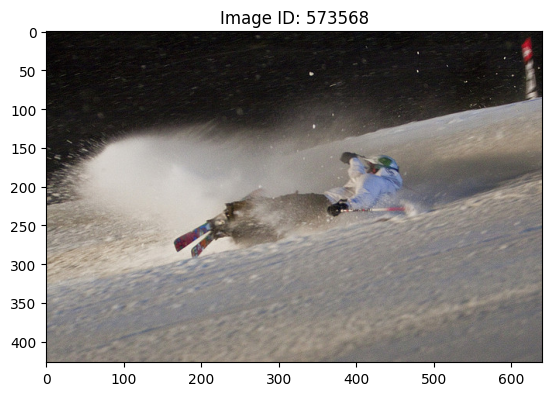

In [ ]:
# Randomly selecting a result with scaled average cosine similarity lower than 0.
low_cosine = cosine_df[cosine_df['scaled_av_cosine'] < 0.6].sample(n=1).squeeze()

# Display information about selected high cosine similarity
print("Low Scaled Average Cosine Similarity Example")
print()
print("Image ID:", low_cosine['image_id'])
print()
print("Predicted Sentence:", ' '.join(low_cosine['generated_caption']))
print()
print("Scaled Average Cosine Similarity:", low_cosine['scaled_av_cosine'])
print()
print("Reference Captions:")
for ref_caption in bleu_df[bleu_df['image_id'] == low_cosine['image_id']]['reference_captions']:
  for cap in ref_caption:
    print("- ", ' '.join(cap))
print()
open_image(low_cosine['image_id'])

## 7 Comparing BLEU and Cosine similarity [16 marks]

13/16

### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below).

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

The scatter plot below illustrates the relationship between the bigram BLEU scores and scaled average cosine similarities for captions generated on the test set.

The distribution of BLEU scores reveals a wide range, with the majority of scores concentrated between 0 and 0.5. Notably, there is a distinct cluster of scores at 0. The high prevalence of low bigram BLEU scores suggests that the generated captions from the model diverge significantly from the reference captions. This indicates a potential challenge in the models’ ability to accurately capture image features and generate appropriate captions. These flaws within the model were apparent during the model’s training, where validation set losses failed to decrease below 3 while training losses diminished.  

Conversely, the scaled average cosine similarity scores indicate a better model performance. The distribution of cosine similarity scores exhibits higher overall values within a narrower range. Most values are concentrated between 0.6 and 0.8, unlike the BLEU scores where most scores lie between 0 and 0.6. A higher similarity is indicated for values closer to 1 and dissimilarity is indicated for values closer to 0. Interestingly, all cosine similarities are above 0.5, indicating there is some level of similarity between every generated caption and its corresponding reference captions.

Despite the variations in bigram BLEU scores and scaled average cosine similarity scores, both metrics indicate that the model has ample room for improvement. While the model generates some captions that exhibit similarity, there are instances where inappropriate and incorrect captions are produced, lacking adequate descriptions of image features.

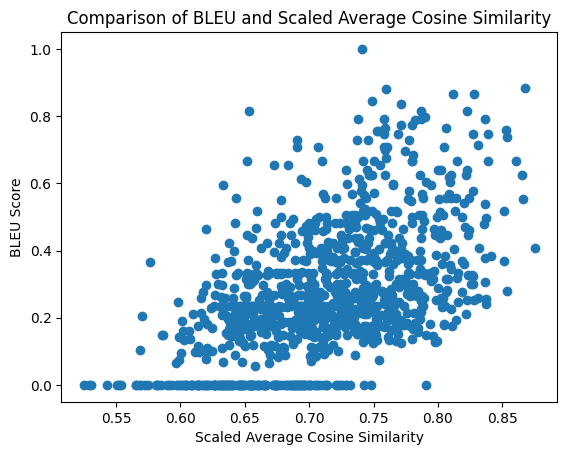

In [ ]:
# Scatter plot od BLEU score and cosine similarity
plt.scatter(cosine_df['scaled_av_cosine'], bleu_df['bleu_score_bi'])
plt.title('Comparison of BLEU and Scaled Average Cosine Similarity')
plt.xlabel('Scaled Average Cosine Similarity')
plt.ylabel('BLEU Score')
plt.show()

The BLEU metric widely employed for evaluating natural language processing tasks such as machine translation and text generation. One reason for this is that it is relatively easy to understand.  It provides a straightforward measure of overlap between generated text and reference text using n-gram precision. Additionally, the BLEU metric boasts computational efficiency, contributing to its popularity in NLP tasks. Its language independence further enhances its universal applicability. Finally, the BLEU score correlates highly with human judgement in some test generation tasks.

Despite these advantages, the BLEU metric has its limitations. Due to the nature of calculations, the metric is not sensitive to synonyms or variation in wording. Instead, it penalizes the system if generated text deviates in wording from the reference, despite maintaining the meaning. The simplicity of the BLEU metric also fails to account for variation in language such as phrases or ways on conveying the same information.

The cosine similarity metric is also widely used in NLP model evaluation. A notable distinction between the BLEU metric and cosine similarity lies in the cosine similarity’s ability to capture semantic context similarity. By measuring the angles between two vectors, the meaning of the phrases is under comparison, contrasting with BLEU metric’s focus on actual word overlap. Additionally, cosine similarity demonstrates robustness towards differences in text length, highlighting its suitability for comparison of texts of varying lengths.

However, the cosine similarity has its limitations. This metric operates on the bag-of-words assumption, where word ordering is not considered. This can sometimes lead to the metric missing contextual information in the generated text and produce unreliable similarity scores.

 ### 7.2 Analysis of individual examples

Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
# Function to return list of image ID's where the score differences is less than or equal to threshold
def find_similar_scores(unique_ids, threshold):
    image_id_list = []
    for image_id in unique_ids:
        bleu_score = bleu_df[bleu_df['image_id'] == image_id]['bleu_score_bi'].values
        cosine_score = cosine_df[cosine_df['image_id'] == image_id]['scaled_av_cosine'].values

        if any(bleu_score) and any(cosine_score) and abs(bleu_score[0] - cosine_score[0]) <= threshold:
            image_id_list.append(image_id)

    return image_id_list

# Function to return list of image ID's where the score differences greater than threshold
def find_different_scores(unique_ids, threshold):
    image_id_list = []
    for image_id in unique_ids:
        bleu_score = bleu_df[bleu_df['image_id'] == image_id]['bleu_score_bi'].values
        cosine_score = cosine_df[cosine_df['image_id'] == image_id]['scaled_av_cosine'].values

        if any(bleu_score) and any(cosine_score) and abs(bleu_score[0] - cosine_score[0]) > threshold:
            image_id_list.append(image_id)

    return image_id_list

In [ ]:
unique_ids = results_df['image_id'].unique()

# Sampling 1 image ID from the list of similar scores and 1 image ID from the list of different scores
similar_scores = random.choice(find_similar_scores(unique_id, 0.05))
different_scores = random.choice(find_different_scores(unique_id, 0.5))

print("Similar Scores")
print("Image ID:", similar_scores)
print()
print("Different Scores")
print("Image ID:", different_scores)

Similar Scores
Image ID: 131415

Different Scores
Image ID: 565258


In [ ]:
similar_scores = 131415
different_scores = 565258

Similar BLEU and Cosine Similarity Scores Example

Image ID: 131415

Bigram BLEU Score: 0.7745966692414834

Scaled Average Cosine Similarity: 0.77969384

Reference Captions:
-  a zebra standing next to a tree on a grass covered field
-  there are some zebras standing by a tree
-  a zebra standing on grass next to a tree
-  there is no photo here to provide a for
-  a zebra is standing in a field of dry grass out side

Predicted Sentence: a giraffe standing next to a tree in a field



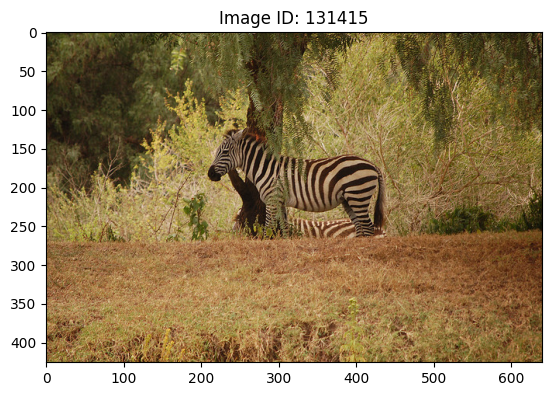

In [ ]:
sim_bleu = bleu_df.loc[bleu_df['image_id'] == similar_scores,'bleu_score_bi'].values[0]
sim_cos = cosine_df.loc[cosine_df['image_id'] == similar_scores,'scaled_av_cosine'].values[0]
generated_cap = bleu_df[bleu_df['image_id'] == similar_scores]['generated_caption'].values[0]

# Display information
print("Similar BLEU and Cosine Similarity Scores Example")
print()
print("Image ID:", similar_scores)
print()
print("Bigram BLEU Score:", sim_bleu)
print()
print("Scaled Average Cosine Similarity:", sim_cos)
print()
print("Reference Captions:")
for ref_caption in bleu_df[bleu_df['image_id'] == similar_scores]['reference_captions']:
  for cap in ref_caption:
    print("- ", ' '.join(cap))
print()
print("Predicted Sentence:", ' '.join(generated_cap))
print()
open_image(similar_scores)

In the example above the BLEU and Cosine similarity scores are very close, 0.77. The generated sentence has many similar words to the reference sentences despite naming the wronmg animal. The generated caption conveys the same meaning as the reference captions, an animal standing near a tree in a field or on grass, so it is not surprising the metrics score similarly.

Different BLEU and Cosine Similarity Scores Example

Image ID: 565258

Bigram BLEU Score: 0.1740776559556978

Scaled Average Cosine Similarity: 0.7677152

Reference Captions:
-  a cat is in a bag
-  a cat is playing with a backpack
-  a cat itself around a backpack
-  a spotted cat underneath a black backpack on the floor
-  a cat is under a backpack on the floor

Predicted Sentence: a dog laying on a bed with a dog and a dog



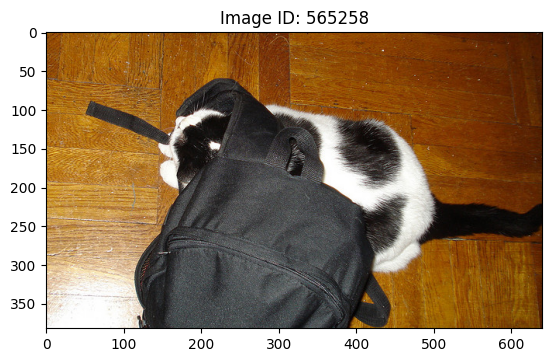

In [ ]:
diff_bleu = bleu_df.loc[bleu_df['image_id'] == different_scores,'bleu_score_bi'].values[0]
diff_cos = cosine_df.loc[cosine_df['image_id'] == different_scores,'scaled_av_cosine'].values[0]
generated_cap = bleu_df[bleu_df['image_id'] == different_scores]['generated_caption'].values[0]

# Display information
print("Different BLEU and Cosine Similarity Scores Example")
print()
print("Image ID:", different_scores)
print()
print("Bigram BLEU Score:", diff_bleu)
print()
print("Scaled Average Cosine Similarity:", diff_cos)
print()
print("Reference Captions:")
for ref_caption in bleu_df[bleu_df['image_id'] == different_scores]['reference_captions']:
  for cap in ref_caption:
    print("- ", ' '.join(cap))
print()
print("Predicted Sentence:", ' '.join(generated_cap))
print()
open_image(different_scores)

In this example, the BLEU score is notably lower than the cosine similarity. The words in the generated caption show limited resemblance to the reference captions, which aligns with the lower BLEU score. However, the cosine similarity is relatively high. This discrepancy might stem from the semantic content conveyed by both the reference captions and the generated caption.

The reference captions depict an animal, specifically a cat, on the floor, engaged in various activities such as playing and being under a backpack. On the other hand, the generated caption describes a different animal, a dog, lying on a bed. This disparity in specific details between the reference and generated captions could contribute to the higher cosine similarity score. It suggests that, despite differences in the choice of words, there is some level of semantic similarity between the content of the reference and generated captions.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2'

/content/drive/MyDrive/Module 7 - Deep Learning/Assessment 2


In [ ]:
!jupyter nbconvert --to html OCOMP5203M_A2.ipynb

[NbConvertApp] Converting notebook OCOMP5203M_A2.ipynb to html
[NbConvertApp] Writing 4868188 bytes to OCOMP5203M_A2.html


### Overall quality [5 marks]

5/5

See the top of the notebook for submission instructions.